# TP  Gradient projeté et gradient conditionnelle (aka Franke-Wolfe)

On cherche dans ce TP à illustrer le comportement de ces deux algos sur un prob
lème jouet

In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets
import scipy as sp
from scipy import optimize

plt.close("all")

def mesh(x_min,x_max,y_min,y_max, h = 0.1):
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


La fonction objective que l'on cherche à optimiser est une fonction 2D
définie par sa Hessienne H, b et c.

In [2]:
H = np.array([[1,-0.5],[-0.5,4]])
b = np.array([2,1])
c = 3
def cout(x):
    return 0.5*x@(H@x) + x@b + c

In [3]:
def Gradient(X):
    return H @ X + b

Afficher les courbes de niveau de cette fonction

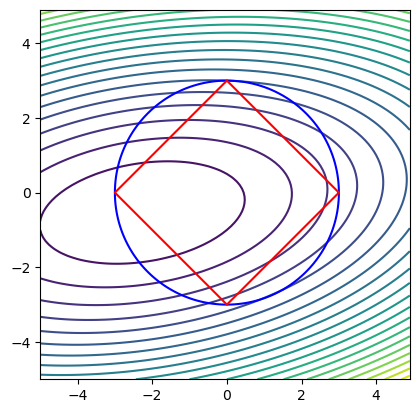

In [4]:
# Z contient tout les points de la grille -5,5
xx, yy  = mesh(-5,5,-5,5)
Cost = np.zeros(xx.shape)
Norme = np.zeros(xx.shape)
Normel1 = np.zeros(xx.shape)

for z in itertools.product(range(len(xx)),range(len(yy))):
    x_point = np.array([xx[z], yy[z]])
    Cost[z] = cout(x_point)
    Norme[z] = np.linalg.norm(x_point, ord=2) 
    Normel1[z] = np.linalg.norm(x_point, ord=1) 

plt.figure(1)
plt.contour(xx, yy, Cost, 20)
plt.contour(xx, yy, Norme, levels=[3], colors='Blue')
plt.contour(xx, yy, Normel1, levels=[3], colors='Red')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Affichez sur cette figure les frontieres de la contraintes suivante

1.  la courbe $\|x\|_2 = 3$

Implémenter un algorithme de gradient projété, avec un backtracking du pas, pour ces deux contraintes 
et tracer l'évolution de $w$ sur ce graphe

In [5]:
def Projection_n2(y, tau=3):
    norm = np.linalg.norm(y)
    if norm <= tau:
        return y
    else:
        return tau * y / norm

In [6]:
def Projection_nl1(y, tau=3):
    norm = np.linalg.norm(y, ord=1)
    if norm <= tau:
        return y
    else:
        return tau * y / norm

In [7]:
def Backtracking(fonc, grad, d, x0):
    sig = 1.0
    c = 1e-4
    rho = 0.5

    while fonc(x0 + sig * d) > fonc(x0) + c * sig * grad(x0).T @ d:
        sig *= rho

    return sig

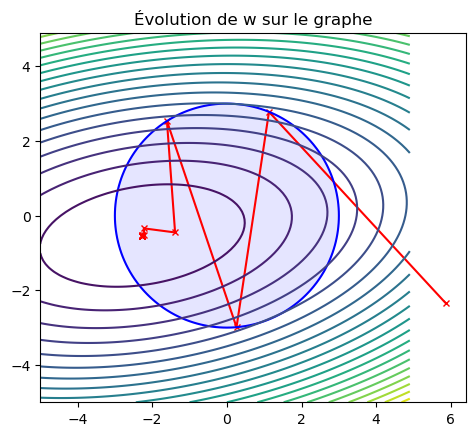

In [8]:
# Boucle d'optimisation
nb_iter = 100
w = np.random.randn(2)*3
m_cout = np.zeros(nb_iter)
mat_w = np.zeros((nb_iter,2))
beta = 0.9
c = 0.5
tho = 1

for i in range(nb_iter):
    mat_w[i] = w    # Liste des w (xlist)
    grad_w = Gradient(w)    
    d = -grad_w
    sig = Backtracking(cout, Gradient, d, w)    # Backtracking pour trouver le pas
    w = w + sig * d     # Mise à jour de w_k
    w = Projection_n2(w) # Calcul de w_k+1

# Tracer l'évolution de w
plt.plot(mat_w[:, 0], mat_w[:, 1], 'r', marker = 'x', ms = 5)
plt.contour(xx, yy, Norme, levels=[3], colors='blue')
circle = plt.Circle((0, 0), 3, color='blue', alpha=0.1) 
plt.gca().add_artist(circle)
plt.contour(xx, yy, Cost, 20)
plt.title('Évolution de w sur le graphe')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

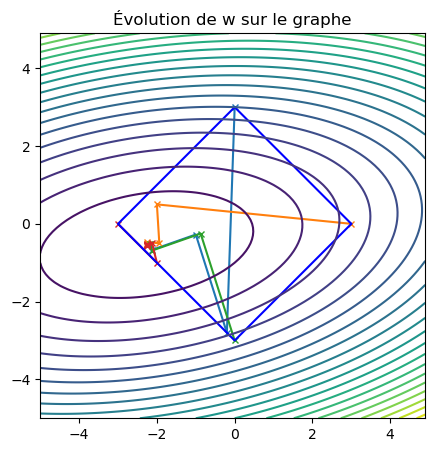

In [9]:
# Points initials
initial_points = np.array([[0, 3], [3, 0], [0, -3], [-3, 0]])
nb_iter = 100 

# Configuração do gráfico
plt.figure(figsize=(5, 5))

for w in initial_points:
    mat_w = np.zeros((nb_iter, 2))  # Liste des w (xlist)
    for i in range(nb_iter):
        mat_w[i] = w 
        grad_w = Gradient(w)
        d = -grad_w
        sig = Backtracking(cout, Gradient, d, w)  # Backtracking pour trouver le pas
        w = w + sig * d  # Mise à jour de w_k
        w = Projection_nl1(w)  # Calcul de w_k+1

    # Tracer l'évolution de w
    plt.plot(mat_w[:, 0], mat_w[:, 1], marker='x', ms=5, label=f'Trajet inicial: {mat_w[0]}')

# Contornos e visualização
plt.contour(xx, yy, Normel1, levels=[3], colors='Blue')
plt.contour(xx, yy, Cost, 20)
plt.title('Évolution de w sur le graphe')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Algorithme de Franke-Wolfe

On cherche à apprendre un modèle de régression sous contrainte de norme $\ell_1$. On cherche
donc à résoudre le probleme
$$
\min_w \frac{1}{2} \|y - Xw\|_2^2  \quad \text{sc} \quad \|w\|_1 \leq \tau
$$

en sachant que 
$$
z = \arg\min_z a^\top z \quad \|w\|_1 \leq \tau
$$
avec $z = -\tau sign(a_k) e_{i_k}$ et $i_k = \arg\max_k |a_k|$


1.   Implémenter l'algorithme de Franke-wolfe correspondant
2.   Appliquer cette algorithme aux données diabetes du TP de regression de ML.
3.   Analyser la forme du minimiseur en fonction de $\tau$
4.   Commenter la solution





In [10]:
def z_nl1(y, tau=3):
    z = np.zeros((len(y)))
    i = np.argmax(abs(y))
    z[i] = - tau*np.sign(y[i])
    return z

In [11]:

def FrankWolf(x0, cout, gradient, zfunc, itermax=100):
    x = [x0.copy()]
    mat_cout = np.zeros(itermax)
    for i in range(itermax):
        z = zfunc(gradient(x[-1]))
        alpha = sp.optimize.golden(lambda a: cout((1 - a)*x[-1] + a*z), brack=(0,1))
        alpha = max(0, min(1, alpha))
        x.append((1-alpha)*x[-1]+alpha*z)
        mat_cout[i] = cout(x[-1])
    return x, mat_cout

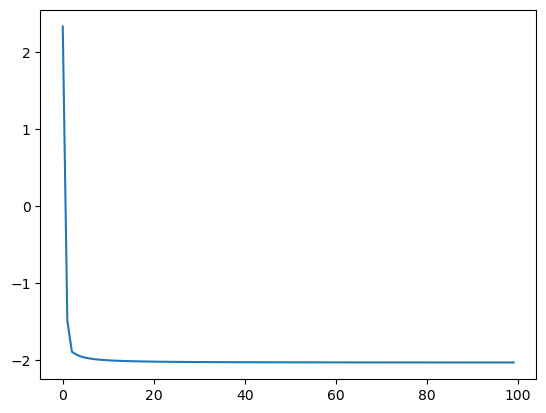

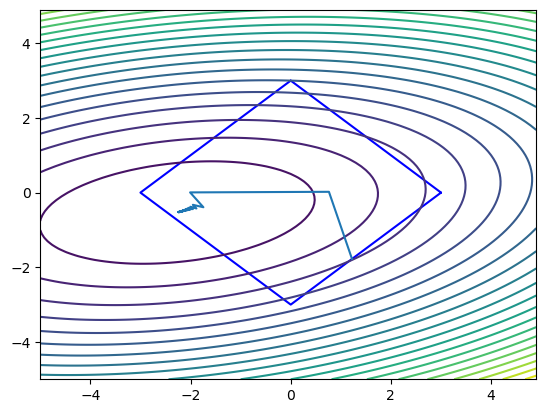

In [12]:
x0 = Projection_nl1((np.random.rand(2)-0.5)*10)
x, mat_cout = FrankWolf(x0, cout, Gradient, z_nl1)
xarray = np.asanyarray(x)

plt.plot(mat_cout)
plt.show()

plt.contour(xx, yy, Normel1, levels=[3], colors='Blue')
plt.contour(xx, yy, Cost, 20)
plt.plot(xarray[:,0], xarray[:,1])
plt.show()

### Algorithme de Franke-Wolfe - Dataset Diabetes

Boston dataset a été supprimé de scikit-learn

In [13]:
def cout(w):
    return 0.5*np.linalg.norm(y - X@w)**2 

def Gradient(w):
    return -X.T @ (y - X @ w)

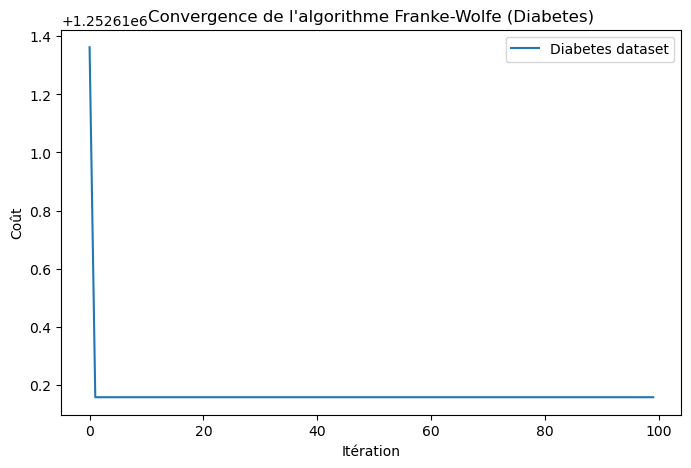

ImportError: 
`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]

Alternative datasets include the California housing dataset and the
Ames housing dataset. You can load the datasets as follows::

    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing()

for the California housing dataset and::

    from sklearn.datasets import fetch_openml
    housing = fetch_openml(name="house_prices", as_frame=True)

for the Ames housing dataset.

[1] M Carlisle.
"Racist data destruction?"
<https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8>

[2] Harrison Jr, David, and Daniel L. Rubinfeld.
"Hedonic housing prices and the demand for clean air."
Journal of environmental economics and management 5.1 (1978): 81-102.
<https://www.researchgate.net/publication/4974606_Hedonic_housing_prices_and_the_demand_for_clean_air>


In [14]:
from sklearn.preprocessing import StandardScaler
datasets_list = ['diabetes', 'boston']

for dataset_name in datasets_list:
    if dataset_name == 'boston':
        data = datasets.load_boston() # `load_boston` has been removed from scikit-learn since version 1.2.
    else:
        data = datasets.load_diabetes()

    X = data["data"]
    y = data["target"]
    d = X.shape[1]

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y = y - np.mean(y)

########################################

    x0 = np.random.rand(d)*0.04
    x, mat_cout = FrankWolf(x0, cout, Gradient, z_nl1)
    xarray = np.asanyarray(x)

    plt.figure(figsize=(8, 5))
    plt.plot(mat_cout, label=f'{dataset_name.capitalize()} dataset')
    plt.xlabel("Itération")    # Título para o eixo x
    plt.ylabel("Coût")          # Título para o eixo y
    plt.title(f"Convergence de l'algorithme Franke-Wolfe ({dataset_name.capitalize()})")  # Título do gráfico
    plt.legend()
    plt.show()